<a href="https://colab.research.google.com/github/lopesmatheus/COA19-PythonSimu/blob/main/Main_PIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PIE - DDPG Continuous

## Prerequisites

In [ ]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 44.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [ ]:
!pip install torch

In [ ]:
!pip install gym

In [3]:
!pip install fmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 KB 15.4 MB/s eta 0:00:00


In [1]:
import gym
import numpy as np
import time

### Environnement Plant

In [4]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from A_T01a import A_T01a
import numpy as np
import shutil
import pandas as pd

In [35]:
# define the model name and simulation parameters

class PlantEnv:
    def __init__(self,CaseTest,Hysteresis,step_size):
        
        self.Hysteresis = Hysteresis     # Définit l'hystérésis de la vanne 0 -> 0%, 1 -> 50%, 2 -> 100%
        
        self.CaseTest = CaseTest         # Reçoit la classe du cas test qui sera simulé (plusieurs ont été codé et
                                         # et ont la même structure pour la simulation)
        
        fmu_plant_filename = 'PLANT_v3_linux.fmu'   # Nom de fichier fmu de la PLANT. Il faudra adapter au cas vous avez changer le
                                              # nom ou le dossier
            
        self.step_size = step_size       # Pas de temps de la simulation
        
        self.Tend = 2000#self.CaseTest.getTsimu() - self.CaseTest.getTend()  # Defini la duree de la simulation

        self.action_space = gym.spaces.Box(0,200,(1,),np.float64)

        self.observation_space=gym.spaces.Box(np.array([-100.0 for i in range(4)]),np.array([300.0 for i in range(4)]),(4,),np.float64)


        # read the model description
        plant_description = read_model_description(fmu_plant_filename)   # Reçoit les paramètres du modèle 

        # collect the value references
        self.plant_vrs = {}                                              # Liste qui reçoit les valeurs de référence de la
                                                                         # plante. Chaque référence identifie soit une entrée 
                                                                         # soit une sortie de la plante.
        for variable in plant_description.modelVariables:
            self.plant_vrs[variable.name] = variable.valueReference

        self.inputs_plant = [v for v in plant_description.modelVariables if v.causality == 'input']  # Recupere tous les valeurs
                                                                                                     # de reference identifiées
                                                                                                     # comme input
                
        self.outputs_plant = [v for v in plant_description.modelVariables if v.causality == 'output'] # Recupere tous les valeurs
                                                                                                      # de reference identifiées
                                                                                                      # comme output

        input_plant_order = []
        
        for v in self.inputs_plant:
            input_plant_order.append(v.valueReference)

        self.CaseTest.setInputOrder(input_plant_order)  # Passe une liste qui définit l'ordre des entrées dans la plant

        # extract the FMU
        # Ces prochaines lignes s'agissent de l'extraction de la fmu (ouverture du fichier) et initialisation comme indiqué dans
        # les exemples de documentation de la librarie fmipy 
        # https://github.com/CATIA-Systems/FMPy/blob/main/fmpy/examples/parameter_variation.py
        
        self.unzipdir_plant = extract(fmu_plant_filename)

        self.fmu_plant = FMU2Slave(guid=plant_description.guid,
                             unzipDirectory=self.unzipdir_plant,
                             modelIdentifier=plant_description.coSimulation.modelIdentifier,
                             instanceName='instance1')

        # initialize
        self.fmu_plant.instantiate()
        self.fmu_plant.setupExperiment(startTime=0)
        self.fmu_plant.enterInitializationMode()
        self.fmu_plant.exitInitializationMode()
        
        self.fmu_plant.setReal([self.inputs_plant[1].valueReference], [self.Hysteresis])   # Définit l'entrée constante de
                                                                                           # l'hysteresis
        
        for cst in self.CaseTest.getConstantsInputs():                  # Ce boucle va reprendre les entrées qui sont definies
            vr = self.inputs_plant[cst].valueReference                  # comme constants au cours de toute la simulation et qui    
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,0)])  # non pas besoin d'être redefinies à chaque iteration
                                                                        # (gain de cout computationelle)
            
        self.T_target = self.CaseTest.getT_tgt_C()                      # Cela prend le vecteur de temperature target
            
        self.counter = 0   # Initialise le counteur
        self.time = 0      # Initialise le temps de simulation

        self.state = np.zeros((self.observation_space.shape[0],)) # Vecteur pour sauvegarder les états d'avant
        
    def reset(self):
        
        # Cette function a pour objectif de faire le "reset" de la plante à fin d'initialiser une nouvelle simulation
        
        self.fmu_plant.reset()
        self.fmu_plant.setupExperiment(startTime=0)    # Initialisation de la nouvelle simulation
        self.fmu_plant.enterInitializationMode()
        self.fmu_plant.exitInitializationMode()
        
        # On doit, à nouveau, definir les entrées qui sont constantes avant le début de la simulation
        
        self.fmu_plant.setReal([self.inputs_plant[1].valueReference], [self.Hysteresis])    
        
        for cst in self.CaseTest.getConstantsInputs():
            vr = self.inputs_plant[cst].valueReference
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,0)])
            
        self.T_target = self.CaseTest.getT_tgt_C()
            
        self.counter = 0
        self.time = 0

        # Comme pendant les 550 premieres pas de temps on ne peut pas commender la vanne
        # de manière à annuler l'erreur, on realise la simulation sans commande pour arriver
        # à un point où les données sont plus utiles à l'entrainement

        init_state=np.zeros((self.observation_space.shape[0],))

        for i in range(550):
          state, reward, done, _ = self.step(0)
          if i>=546:
            init_state[i-546]=state[0]

        self.state = init_state

        #print(self.state)

        return(init_state)
        
    def step(self, action):
        for var in self.CaseTest.getVariablesInputs():             # Define tous les variables qui change à chaque pas de temps
            vr = self.inputs_plant[var].valueReference             # en fonction de ce qui est code dans le cas test
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,self.counter)])
            
        self.fmu_plant.setReal([self.inputs_plant[0].valueReference], [action])    # Passe l'action qui sera faite à la plante
        
        self.fmu_plant.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size) # Simule 1 pas de temps
                                                                                                         # de la plante
        
        self.counter += 1
        self.time += self.step_size
        
        if self.time < self.Tend:            # Identifie si la simulation est terminée
            done = False
        else:
            done = True
        
        TBAS_SENSOR = self.fmu_plant.getReal([self.outputs_plant[4].valueReference])[0]    # Prend la temperature de sortie
                                                                                           # de la plante
        
        T_target = self.CaseTest.getT_tgt_C()
        
        error = abs(TBAS_SENSOR - T_target[0])
        
        #reward = - error**2 #- 100 * max(self.time-60,0) * max(error-10,0) - 100 * max(self.time-120,0) * max(error-5,0)    
        reward = - (error / T_target[0])**2
        
        self.state[0:len(self.state)-1] = self.state[1:len(self.state)]   # Actualise les états d'avant qui l'on garde
        self.state[len(self.state)-1] = TBAS_SENSOR
            

        return self.state, reward, done, _
    
    def kill_plant(self):                   # Après la simulation, on peut "tuer" la plante et la "déinstancier"
        self.fmu_plant.terminate()
        self.fmu_plant.freeInstance()

        # clean up
        shutil.rmtree(self.unzipdir_plant, ignore_errors=True)

### Agent

To simplify the global code of this notebook, we will use a mother class for each of our agents. This will allow us to build a simulation function that take in argument an environment and an agent, and work with any agents and any environments. Then all you will have to do is to describe what the agent should do at each step of the learning.

In [36]:
import random
import torch
from torch import nn
from statistics import mean
import matplotlib.pyplot as plt
import copy

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
class ReplayBuffer:
    def __init__(self, capacity, device=DEVICE):
        self.capacity = capacity # capacity of the buffer
        self.device = device
        self.data = []
        self.index = 0 # index of the next cell to be filled

    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(x).to(self.device), list(zip(*batch))))

    def __len__(self):
        return len(self.data)

class Agent:
    """
    An global agent class that describe the interactions between our agent and it's environment
    """
    def __init__(self, state_space, action_space, device=DEVICE, name="base_agent"):

        self.name = name  # The name is used inside plot legend, outputs directory path, and outputs file names

        self.state_space = state_space
        self.state_shape = state_space.shape
        self.state_size = state_space.shape[0]  # Assume state space is continuous

        self.continuous = isinstance(action_space, gym.spaces.Box)
        self.action_space = action_space
        self.nb_actions = self.action_space.shape[0] if self.continuous else self.action_space.n
        print(self.nb_actions)
        self.last_state = None  # Useful to store interaction when we recieve (new_stare, reward, done) tuple
        self.device = device
        self.episode_id = 0
        self.episode_time_step_id = 0
        self.time_step_id = 0
    
    def on_simulation_start(self):
        """
        Called when an episode is started. will be used by child class.
        """
        pass
    
    def on_episode_start(self, state):
        self.last_state = state
        self.episode_time_step_id = 0
        self.episode_id = 0

    def action(self, state):
        res = self.action_space.sample()
        return res

    def on_action_stop(self, action, new_state, reward, done):
        self.episode_time_step_id += 1
        self.time_step_id += 1
        self.last_state = new_state

    def on_episode_stop(self):
        self.episode_id += 1

    def on_simulation_stop(self):
        pass


cuda


Now let's build a function that run a simulation where a given agent interact with a givent environment. 

## Actor-critic

<div id="actor_critic"></div>
To understand in detail how it work, we are going to implement two of the most known off-policy actor critic architectures, Deep-Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC). 

### Deep-Deterministic Policy Gradient (DDPG)

<div id="ddpg"></div>

DDPG is considered as an off-policy algorithm, because the policy used to train the critic is different than the one used to generate samples.

For the general idea, when we select an interaction (s, a, r, s', a') to train our critic network, the way a' will be chosen will define the reward propagation (generally called credit assignment) speed. If a' is the optimal action from s', like in DQN, there is a high probability to get an action that lead in interestig and highly valuated states s''. In that case, the high values and the rewards will be propagated to (s, a) value, more frequently than s'' with low value.

If you didn't got it, you can also check this course from Olivier SIGAUD on youtube : https://youtu.be/hlhzvQnXdAA

Note that the default DDPG algorithm don't use epsilon-greedy, but add a noise on the action to make it explore. The original paper use a OU-noise, but for simplicity, we will generate a gaussian noise N(mean, std) to noise our action.


In [7]:
from torch import optim

def init_weights(layer, bound=None):
    if bound is None:
        bound = 1. / np.sqrt(layer.weight.data.size()[0])
    torch.nn.init.uniform_(layer.weight.data, -bound, bound)
    torch.nn.init.uniform_(layer.bias.data, -bound, bound)


class DefaultNNActor(nn.Module):
    def __init__(self, learning_rate, input_dims, layer_1_dims, layer_2_dims, output_dims, device,
                 last_activation=None):
        super().__init__()
        self.last_activation = last_activation
        self.layer_1 = nn.Linear(input_dims, layer_1_dims)
        init_weights(self.layer_1)
        self.layer_norm_1 = nn.LayerNorm(layer_1_dims)

        self.layer_2 = nn.Linear(layer_1_dims, layer_2_dims)
        init_weights(self.layer_2)
        self.layer_norm_2 = nn.LayerNorm(layer_2_dims)

        self.layer_3 = nn.Linear(layer_2_dims, output_dims)
        init_weights(self.layer_3, bound=0.003)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.device = device
        self.to(self.device)

    def forward(self, inputs):
        running_output = self.layer_1(inputs)
        running_output = self.layer_norm_1(running_output)
        running_output = torch.nn.functional.relu(running_output)
        running_output = self.layer_2(running_output)
        running_output = self.layer_norm_2(running_output)
        running_output = torch.nn.functional.relu(running_output)
        running_output = self.layer_3(running_output)
        running_output = torch.tanh(running_output)

        running_output = 152.5 + 27.5 * running_output

        return running_output

    def converge_to(self, other_model, tau=0.01):
        """
        Make the value of parameters of this model converge to one from the given model.
        The parameter tau indicate how close our weights should be from the one of the other model.
        self.converge_to(other_model, tau=1) is equivalent to self = copy.deepcopy(other_model).

        other_model should have the same shape, dimensions, than self.
        """
        for self_param, other_param in zip(self.parameters(), other_model.parameters()):
            self_param.data.copy_(
                self_param.data * (1.0 - tau) + other_param.data * tau
            )

class DefaultNNCritic(nn.Module):
    def __init__(self, learning_rate, input_dims, layer_1_dims, layer_2_dims, output_dims, device,
                 last_activation=None):
        super().__init__()
        self.last_activation = last_activation
        self.layer_1 = nn.Linear(input_dims, layer_1_dims)
        init_weights(self.layer_1)
        self.layer_norm_1 = nn.LayerNorm(layer_1_dims)

        self.layer_2 = nn.Linear(layer_1_dims, layer_2_dims)
        init_weights(self.layer_2)
        self.layer_norm_2 = nn.LayerNorm(layer_2_dims)

        self.layer_3 = nn.Linear(layer_2_dims, output_dims)
        init_weights(self.layer_3, bound=0.003)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.device = device
        self.to(self.device)


    def forward(self, inputs):
        running_output = self.layer_1(inputs)
        running_output = self.layer_norm_1(running_output)
        running_output = torch.nn.functional.relu(running_output)
        running_output = self.layer_2(running_output)
        running_output = self.layer_norm_2(running_output)
        running_output = torch.nn.functional.relu(running_output)
        running_output = self.layer_3(running_output)

        if self.last_activation is not None:
            running_output = self.last_activation(running_output)
        return running_output

    def converge_to(self, other_model, tau=0.01):
        """
        Make the value of parameters of this model converge to one from the given model.
        The parameter tau indicate how close our weights should be from the one of the other model.
        self.converge_to(other_model, tau=1) is equivalent to self = copy.deepcopy(other_model).

        other_model should have the same shape, dimensions, than self.
        """
        for self_param, other_param in zip(self.parameters(), other_model.parameters()):
            self_param.data.copy_(
                self_param.data * (1.0 - tau) + other_param.data * tau
            )

In [18]:
def simulation(environment, agent, nb_episodes=200, verbose=True):
    episodes_rewards_sum = []
    agent.on_simulation_start()
    for episode_id in range(nb_episodes):
        state = environment.reset()
        agent.on_episode_start(state)

        episode_rewards = []
        done = False
        prev=np.zeros((1,))

        x=[]
        actions=[]
        while not done:
            action = agent.action(state)
            actions.append(action)
            x.append(state[-1])
            state, reward, done ,_= environment.step(action)
            
            # Ending time step process ...
            agent.on_action_stop(action, state, reward, done)

            # Store reward
            episode_rewards.append(reward)

        agent.on_episode_stop()
        rewards_sum = sum(episode_rewards)
        episodes_rewards_sum.append(rewards_sum)
        #environment.close()
        if len(episodes_rewards_sum) > 20:
            last_20_average = mean(episodes_rewards_sum[-20:])
        else:
            last_20_average = mean(episodes_rewards_sum)

        if verbose:
            print("Episode ", '{:3d}'.format(episode_id),
                  ", episode return ", '{:4.1f}'.format(rewards_sum),
                  ", last 20 avg ", '{:4.1f}'.format(last_20_average),
                  sep='')
            t=range(int(1.0/float(step_size)*1450))
            plt.figure()
            plt.plot(t,x)
            plt.plot(t,[CaseTest.getT_tgt_C() for i in range(1450)])
            plt.xlabel('t (step)')
            plt.ylabel('x')

            plt.figure()
            plt.plot(t,actions)

            plt.show()
    return episodes_rewards_sum

1
DefaultNNActor(
  (layer_1): Linear(in_features=4, out_features=512, bias=True)
  (layer_norm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layer_3): Linear(in_features=256, out_features=1, bias=True)
)
Episode   0, episode return -937.2, last 20 avg -937.2


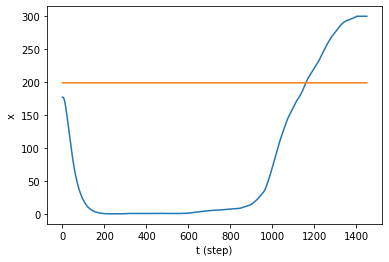

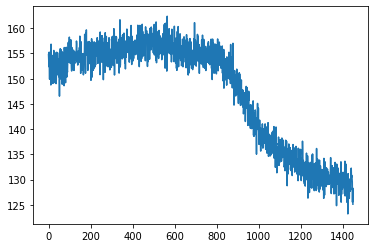

Episode   1, episode return -189.8, last 20 avg -563.5


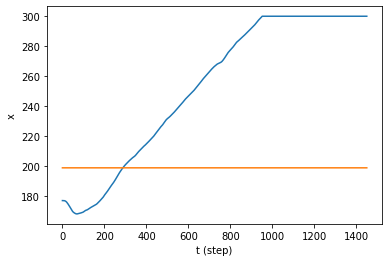

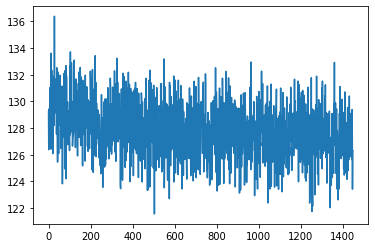

Episode   2, episode return -196.4, last 20 avg -441.1


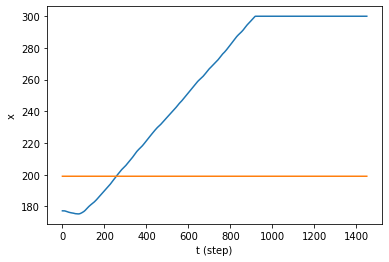

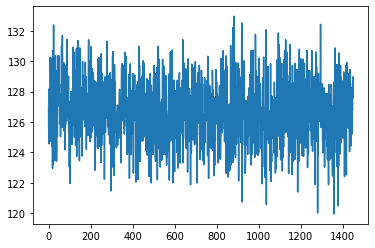

Episode   3, episode return -177.8, last 20 avg -375.3


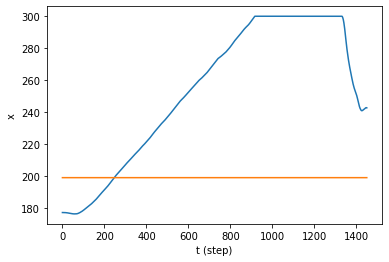

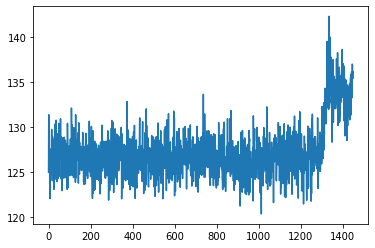

Episode   4, episode return -65.8, last 20 avg -313.4


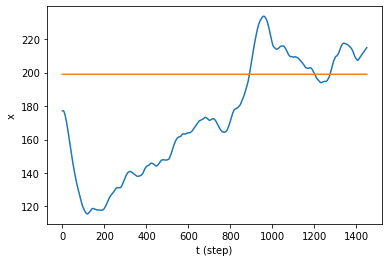

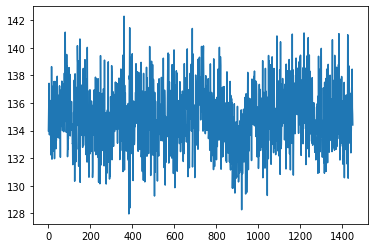

Episode   5, episode return -84.1, last 20 avg -275.2


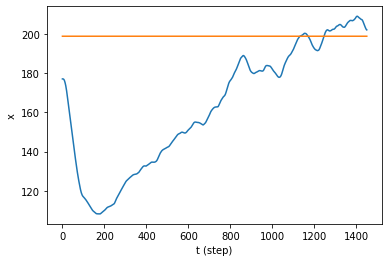

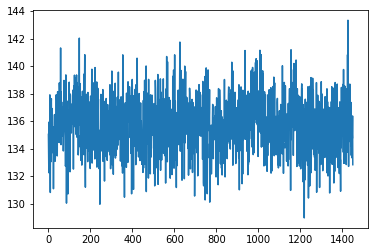

Episode   6, episode return -75.8, last 20 avg -246.7


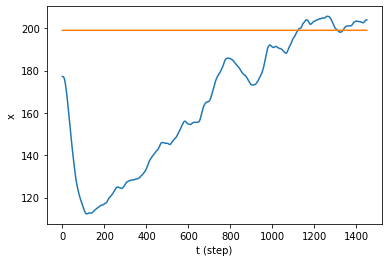

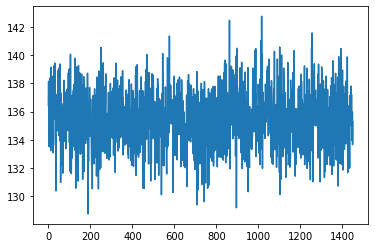

Episode   7, episode return -88.8, last 20 avg -226.9


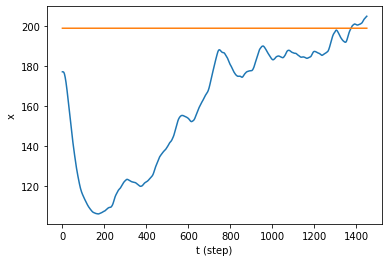

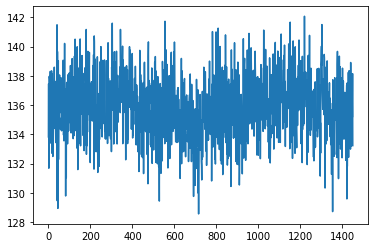

Episode   8, episode return -56.1, last 20 avg -208.0


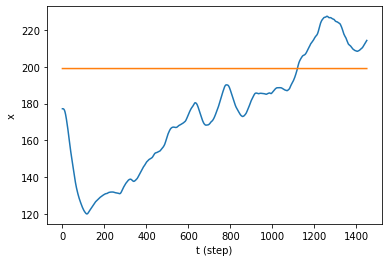

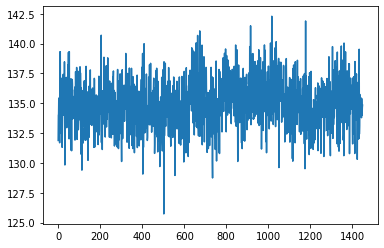

In [ ]:
# %load solutions/RL6_DDPG.py
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

### NEW indicate the differences between DQN and DDPG.
class DDPGAgent(Agent):
    def __init__(self, state_space, action_space, device, actor_lr=0.000005, critic_lr=0.00001, tau=0.001, gamma=0.99,
                 max_size=100000, layer1_size=512, layer2_size=256, batch_size=64, noise_std=0.1, name="DDPG"):
        assert isinstance(action_space, gym.spaces.Box)  ### NEW: The action space is now continuous 
        super().__init__(state_space, action_space, device=device, name=name)
        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer(max_size, self.device)
        self.batch_size = batch_size

        self.actor = DefaultNNActor(actor_lr, self.state_size, layer1_size, layer2_size, self.nb_actions
                               , self.device)
        self.critic = DefaultNNCritic(critic_lr, self.state_size + self.nb_actions, layer1_size, layer2_size, 1, self.device)

        print(self.actor)

        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)

        self.normal_distribution = torch.distributions.normal.Normal(
            torch.zeros(self.nb_actions), torch.full((self.nb_actions,), noise_std))

    def action(self, observation):
        with torch.no_grad():
            observation = torch.tensor(observation, dtype=torch.float).to(self.device)
            actor_output = self.actor.forward(observation).to(self.device)
            #action=torch.normal(actor_output[0], np.abs(actor_output[1]))
            noise = self.normal_distribution.sample().to(self.device)
            action = actor_output + noise
        return action.cpu().detach().numpy()

    def on_action_stop(self, action, new_state, reward, done):
        self.replay_buffer.append(self.last_state, action, reward, new_state, done)
        self.learn()
        super().on_action_stop(action, new_state, reward, done)

    def learn(self):
        #if len(self.replay_buffer) > self.batch_size:
        if len(self.replay_buffer.data) > self.batch_size:
            states, actions, rewards, new_states, dones = self.replay_buffer.sample(self.batch_size)

            with torch.no_grad():
                target_actions = self.target_actor.forward(new_states)
                critic_value_ = self.target_critic.forward(torch.concat((new_states, target_actions), dim=-1))
            critic_value = self.critic.forward(torch.concat((states, actions), dim=-1))
            target = torch.addcmul(rewards, self.gamma, 1 - dones, critic_value_.squeeze()).view(self.batch_size, 1)
            self.critic.optimizer.zero_grad()
            critic_loss = torch.nn.functional.mse_loss(target, critic_value)
            critic_loss.backward()
            self.critic.optimizer.step()

            self.actor.optimizer.zero_grad()
            actions = self.actor.forward(states)
            actor_loss = - self.critic.forward(torch.concat((states, actions), dim=-1))
            actor_loss = torch.mean(actor_loss)
            actor_loss.backward()
            self.actor.optimizer.step()

            self.target_critic.converge_to(self.critic, tau=self.tau)
            self.target_actor.converge_to(self.actor, tau=self.tau)

# Test our agent on Pendulum-v0
#environment = gym.make('Pendulum-v1')
#environment = CarPend()
step_size = 1
CaseTest = A_T01a(step_size)  
environment = PlantEnv(CaseTest,0.0,step_size)
#agent = DDPGAgent(environment.observation_space, environment.action_space, device=DEVICE)
#simulation(environment, agent,nb_episodes=5000)

agent = DDPGAgent(environment.observation_space, environment.action_space, noise_std=2, device=DEVICE)
simulation(environment, agent,nb_episodes=1000)

In [ ]:

torch.save(agent.actor.state_dict(), 'act_checkpoint.pth')
#agent.critic.save('act_checkpoint.pth')
torch.save(agent.critic.state_dict(), 'crit_checkpoint.pth')